In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load

In [34]:
dir_raw_dataset = 'data/Furniture_Data'
sub_folders = [sub_folder for sub_folder in os.listdir(dir_raw_dataset) if os.path.isdir(os.path.join(dir_raw_dataset, sub_folder))]
print(sub_folders)

['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']


In **Task 1 EDA & Preprocess**, we already analyze our raw data including removing duplicated images, saving image paths into csv and plotting data distribution. Hence, we will reuse our **df_clean.csv** for further data exploratory.

In [3]:
# Load the dataset for Exploratory Data Analysis purpose
data_eda = pd.read_csv('./data/df_clean.csv')
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81335 entries, 0 to 81334
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  81335 non-null  object
 1   Class    81335 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


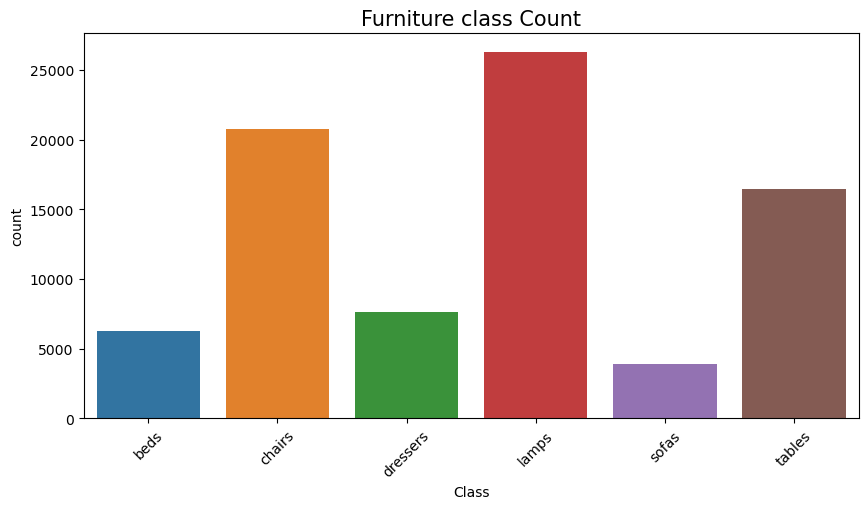

In [4]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=data_eda, x='Class') 
plt.title("Furniture class Count", fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [5]:
def get_image_style(full_path):
    # Normalize the path to avoid issues with different OS path separators
    normalized_path = os.path.normpath(full_path)
    
    # Split the path into parts
    path_parts = normalized_path.split(os.sep)
    # return path_parts
    
    # Get the last three components of the path
    image_style = path_parts[3]
    
    return image_style

In [6]:
df_style = data_eda['ImgPath'].apply(get_image_style)
data_eda['Style'] = data_eda['ImgPath'].apply(get_image_style)

In [7]:
data_eda = data_eda.reset_index(drop=True)
data_eda.to_csv('./data/df_clean_Task3_2.csv', index=False)

In [8]:
data_eda.head()

,ImgPath,Class,Style
0,data/Furniture_Data\beds\Asian\20027asian-cano...,beds,Asian
1,data/Furniture_Data\beds\Asian\20109asian-pane...,beds,Asian
2,data/Furniture_Data\beds\Asian\2537asian-platf...,beds,Asian
3,data/Furniture_Data\beds\Asian\2637asian-platf...,beds,Asian
4,data/Furniture_Data\beds\Asian\2709asian-platf...,beds,Asian


In [9]:
style_counts = data_eda.groupby(['Class', 'Style']).size().reset_index(name='counts')
style_counts.head()

,Class,Style,counts
0,beds,Asian,44
1,beds,Beach,44
2,beds,Contemporary,1802
3,beds,Craftsman,176
4,beds,Eclectic,22


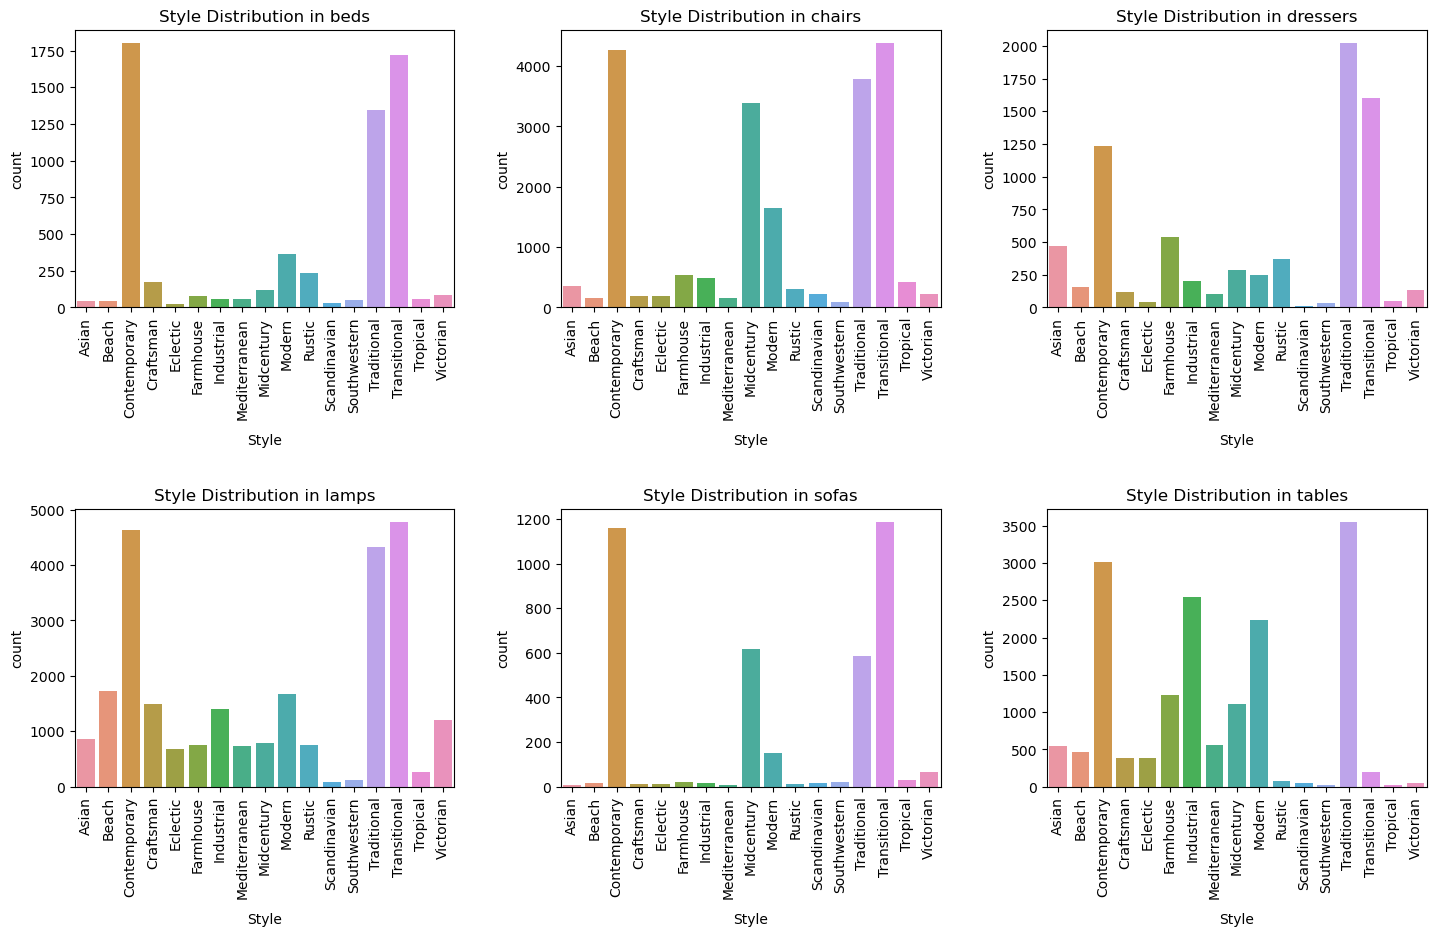

In [10]:
# Unique classes
classes = data_eda['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=data_eda[data_eda['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [11]:
# Group by 'class' and count unique 'style'
style_counts_per_class = data_eda.groupby('Class')['Style'].nunique()

# Print the result
print(style_counts_per_class)

Class
beds        17
chairs      17
dressers    17
lamps       17
sofas       17
tables      17
Name: Style, dtype: int64


In [12]:
# Group by 'class' and 'style', then count occurrences
style_counts = data_eda.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian              44
          Beach              44
          Contemporary     1802
          Craftsman         176
          Eclectic           22
          Farmhouse          80
          Industrial         58
          Mediterranean      60
          Midcentury        116
          Modern            367
          Rustic            235
          Scandinavian       32
          Southwestern       48
          Traditional      1347
          Transitional     1717
          Tropical           55
          Victorian          83
chairs    Asian             349
          Beach             161
          Contemporary     4264
          Craftsman         196
          Eclectic          188
          Farmhouse         530
          Industrial        489
          Mediterranean     158
          Midcentury       3379
          Modern           1652
          Rustic            299
          Scandinavian      216
          Southwestern       92
          Tradit

# Train Test Split

In [13]:
df_clean = pd.read_csv('./data/df_clean_Task3_2.csv')

df_X = df_clean.drop(['Class', 'Style'], axis = 1)
df_Y = df_clean[['Class', 'Style']]
# split data 70% train, 15% val, %15 test
train_val_X, test_X, train_val_Y, test_Y = train_test_split( df_X, df_Y, shuffle=True, test_size=0.15, random_state=42)
train_X, val_X, train_Y, val_Y = train_test_split( train_val_X, train_val_Y, shuffle=True, test_size=0.17, random_state=42)

print(f"train_X shape: {train_X.shape}")
print(f"train_Y shape: {train_Y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_Y shape: {val_Y.shape}")
print(f"test_X shape: {val_X.shape}")
print(f"test_Y shape: {val_Y.shape}")

train_X shape: (57381, 1)
train_Y shape: (57381, 2)
val_X shape: (11753, 1)
val_Y shape: (11753, 2)
test_X shape: (11753, 1)
test_Y shape: (11753, 2)


In [14]:
df_clean.head()

,ImgPath,Class,Style
0,data/Furniture_Data\beds\Asian\20027asian-cano...,beds,Asian
1,data/Furniture_Data\beds\Asian\20109asian-pane...,beds,Asian
2,data/Furniture_Data\beds\Asian\2537asian-platf...,beds,Asian
3,data/Furniture_Data\beds\Asian\2637asian-platf...,beds,Asian
4,data/Furniture_Data\beds\Asian\2709asian-platf...,beds,Asian


In [15]:
# Save to csv
train_X.to_csv("./data/X_train_before_transformed_Task3_2.csv", index=False)
train_Y.to_csv("./data/Y_train_before_transformed_Task3_2.csv", index=False)
val_X.to_csv("./data/X_val_Task3_2.csv", index=False)
val_Y.to_csv("./data/Y_val_Task3_2.csv", index=False)
test_X.to_csv("./data/X_test_Task3_2.csv", index=False)
test_Y.to_csv("./data/Y_test_Task3_2.csv", index=False)

#### Plotting figures after splitting

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


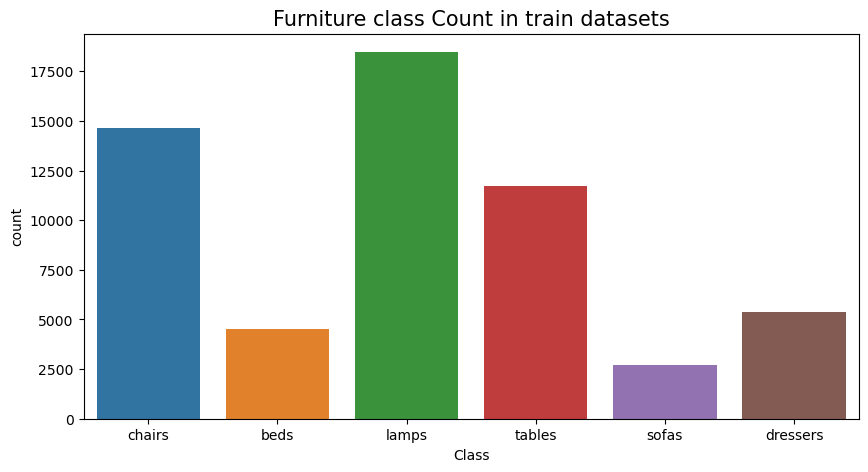

lamps       18465
chairs      14652
tables      11700
dressers     5366
beds         4498
sofas        2700
Name: Class, dtype: int64

In [16]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(train_Y['Class'])
plt.title("Furniture class Count in train datasets", fontsize = 15)
plt.show()

train_Y['Class'].value_counts()

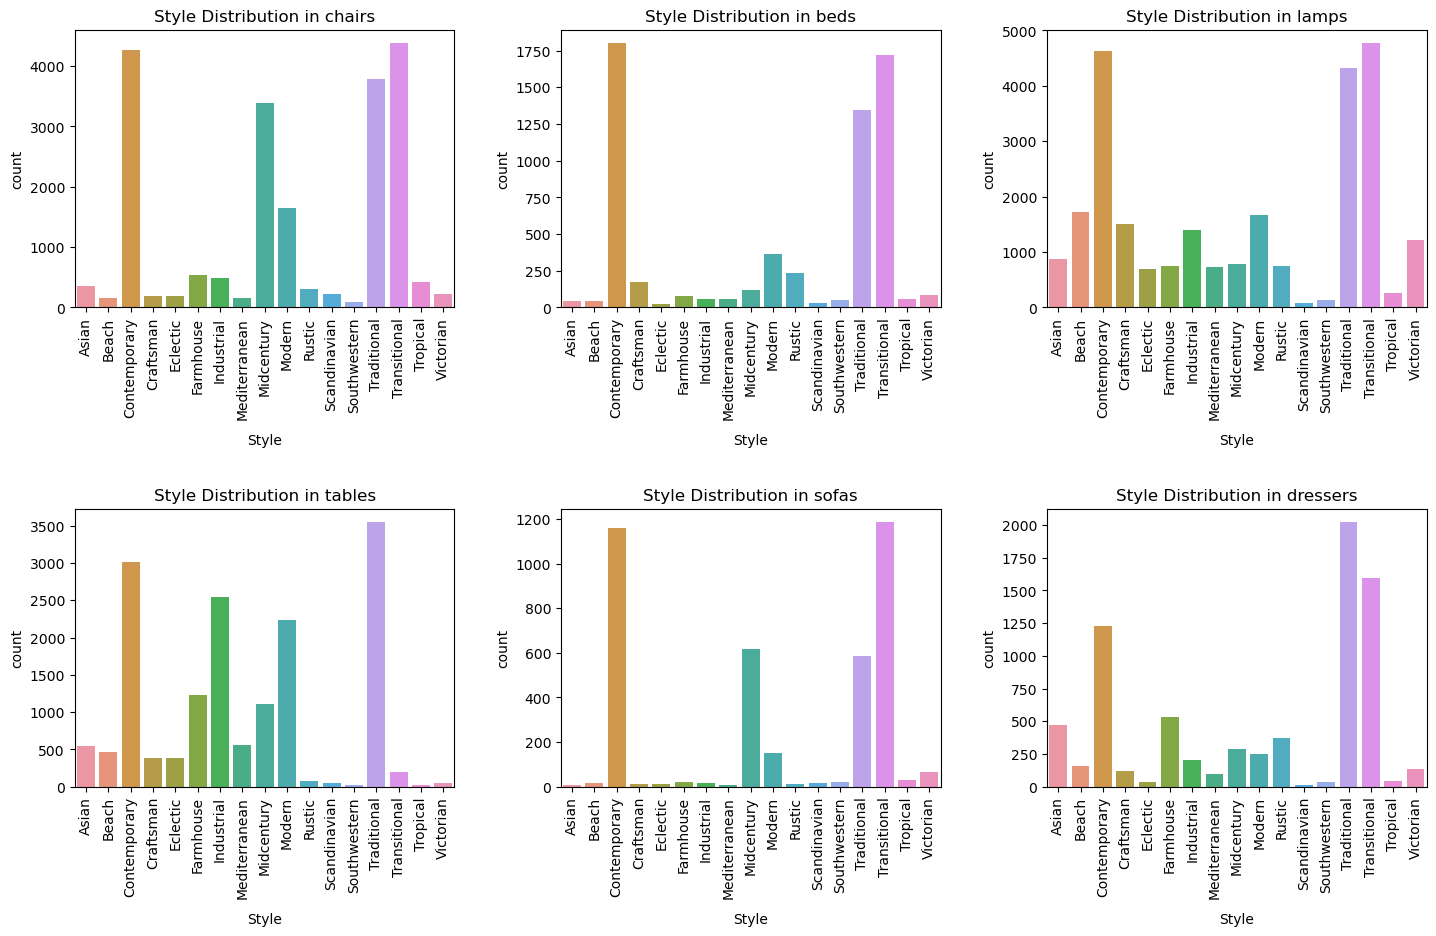

In [17]:
# Unique classes
classes = train_Y['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=data_eda[data_eda['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [18]:
# Group by 'class' and 'style', then count occurrences
style_counts = train_Y.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian              35
          Beach              41
          Contemporary     1291
          Craftsman         129
          Eclectic           15
          Farmhouse          57
          Industrial         37
          Mediterranean      41
          Midcentury         74
          Modern            260
          Rustic            162
          Scandinavian       22
          Southwestern       37
          Traditional       955
          Transitional     1251
          Tropical           36
          Victorian          55
chairs    Asian             242
          Beach             101
          Contemporary     2966
          Craftsman         151
          Eclectic          130
          Farmhouse         373
          Industrial        338
          Mediterranean     103
          Midcentury       2395
          Modern           1175
          Rustic            213
          Scandinavian      158
          Southwestern       61
          Tradit

## Handling class imbalance

To handle the imbalanced datasets, we will resample the datasets to the average occurences for all styles.

In [19]:
train_Y = pd.read_csv('./data/Y_train_before_transformed_Task3_2.csv')
style_counts = train_Y.groupby(['Class', 'Style']).size()
NUM_STYLES = len(train_Y['Style'].unique())
NUM_CLASSES = len(train_Y['Class'].unique())
total_occurences = style_counts.sum()
average_occurences = total_occurences // (NUM_STYLES * NUM_CLASSES)
print(f'Total classes: {NUM_CLASSES}')
print(f'Total styles: {NUM_STYLES}')
print(f'Total occurences: {total_occurences}')
print(f'Average occurences: {average_occurences}')

Total classes: 6
Total styles: 17
Total occurences: 57381
Average occurences: 562


In [20]:
from imgaug import augmenters as iaa

def create_augmentation_sequence():
    return iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                   translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                   rotate=(-25, 25),
                   shear=(-8, 8))
    ])


After this step, we decide the number of samples for each style will be **200**.

In [21]:
def augment_images(df, category, style, folder_path, target_count=200):
    # Filter DataFrame by category
    category_style_df = df[(df['Class'] == category) & (df['Style'] == style)]
    current_count = len(category_style_df)
    # print(category, style, current_count)
    seq = create_augmentation_sequence()

    output_category_dir = os.path.join(folder_path, category)
    if not os.path.exists(output_category_dir):
        os.makedirs(output_category_dir)
        
    output_style_dir = os.path.join(output_category_dir, style)
    if not os.path.exists(output_style_dir):
        os.makedirs(output_style_dir)

    # While loop to keep generating until we reach the target count
    while current_count < target_count:
        for _, row in category_style_df.iterrows():
            img_path = row['ImgPath']
            try:
                image = Image.open(img_path)
                image_np = np.array(image)  # Convert to numpy array for augmentation
                augmented_image_np = seq(images=[image_np])[0] 
                augmented_image = Image.fromarray(augmented_image_np)
                augmented_image.save(os.path.join(output_style_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{current_count}.png"))
                current_count += 1
                if current_count >= target_count:
                    break
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    # return data

In [22]:
df_X_before_transformed = pd.read_csv('./data/X_train_before_transformed_Task3_2.csv')
df_Y_before_transformed = pd.read_csv('./data/Y_train_before_transformed_Task3_2.csv')
df_before_transformed = pd.concat([df_X_before_transformed, df_Y_before_transformed], axis=1)

In [23]:
df_before_transformed.head()

,ImgPath,Class,Style
0,data/Furniture_Data\chairs\Traditional\12810tr...,chairs,Traditional
1,data/Furniture_Data\chairs\Modern\7085modern-d...,chairs,Modern
2,data/Furniture_Data\chairs\Transitional\9280tr...,chairs,Transitional
3,data/Furniture_Data\chairs\Midcentury\8604midc...,chairs,Midcentury
4,data/Furniture_Data\chairs\Traditional\13478tr...,chairs,Traditional


In [24]:
augmentation_path = 'augmentation_Task3_2'
categories = df_before_transformed['Class'].unique()
styles = df_before_transformed['Style'].unique()
print(categories)
print(styles)

if not os.path.exists(augmentation_path):
    os.makedirs(augmentation_path)

for category in categories:
    for style in styles:
        augment_images(df_before_transformed, category, style, augmentation_path, 200)

['chairs' 'beds' 'lamps' 'tables' 'sofas' 'dressers']
['Traditional' 'Modern' 'Transitional' 'Midcentury' 'Scandinavian'
 'Contemporary' 'Beach' 'Industrial' 'Craftsman' 'Asian' 'Tropical'
 'Mediterranean' 'Farmhouse' 'Rustic' 'Eclectic' 'Victorian'
 'Southwestern']


In [25]:
def load_csv(dataset_folder, label_category, label_style, prompt = ""):
    # Folder path containing the images
    folder_path = dataset_folder  

    # List all files in the folder
    file_list = os.listdir(folder_path)
    data_csv = []
    for file_name in file_list:
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        if os.path.isfile(file_path):
            data_csv.append([file_path, label_category, label_style])
    return data_csv

In [26]:
data_augmenation_csv = []
augmentation_path = 'augmentation_Task3_2'
for category in categories:
    print("Accessing category " + category)
    for style in styles:
        print("\tAccessing style " + style)
        folder_path = os.path.join(augmentation_path, category, style)
        datas = load_csv(folder_path, category, style)
        data_augmenation_csv.extend(datas)

print('Load augmentation data successfully')

Accessing category chairs
	Accessing style Traditional
	Accessing style Modern
	Accessing style Transitional
	Accessing style Midcentury
	Accessing style Scandinavian
	Accessing style Contemporary
	Accessing style Beach
	Accessing style Industrial
	Accessing style Craftsman
	Accessing style Asian
	Accessing style Tropical
	Accessing style Mediterranean
	Accessing style Farmhouse
	Accessing style Rustic
	Accessing style Eclectic
	Accessing style Victorian
	Accessing style Southwestern
Accessing category beds
	Accessing style Traditional
	Accessing style Modern
	Accessing style Transitional
	Accessing style Midcentury
	Accessing style Scandinavian
	Accessing style Contemporary
	Accessing style Beach
	Accessing style Industrial
	Accessing style Craftsman
	Accessing style Asian
	Accessing style Tropical
	Accessing style Mediterranean
	Accessing style Farmhouse
	Accessing style Rustic
	Accessing style Eclectic
	Accessing style Victorian
	Accessing style Southwestern
Accessing category lamps

In [27]:
df_augmentation = pd.DataFrame(data_augmenation_csv)
df_augmentation.rename(columns = {0:'ImgPath', 1:'Class', 2:'Style'}, inplace = True)
df_X_before_transformed = pd.read_csv('./data/X_train_before_transformed_Task3_2.csv')
df_Y_before_transformed = pd.read_csv('./data/Y_train_before_transformed_Task3_2.csv')
df_before_transformed = pd.concat([df_X_before_transformed, df_Y_before_transformed], axis=1)

df_sampling = pd.concat([df_before_transformed, df_augmentation], ignore_index=True)
df_sampling.to_csv('./data/df_sampling_Task3_2.csv', index = False)

# Group by the category and style and then sample
df_final = df_sampling.groupby(['Class', 'Style']).apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
# df_final['Class'].value_counts()
df_final.to_csv('./data/df_final_Task3_2.csv', index = False)


In [28]:
df_final.head()

,ImgPath,Class,Style
0,augmentation_Task3_2\beds\Asian\8109asian-pane...,beds,Asian
1,augmentation_Task3_2\beds\Asian\3110asian-plat...,beds,Asian
2,augmentation_Task3_2\beds\Asian\3368asian-pane...,beds,Asian
3,augmentation_Task3_2\beds\Asian\7957asian-plat...,beds,Asian
4,augmentation_Task3_2\beds\Asian\8109asian-pane...,beds,Asian


C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


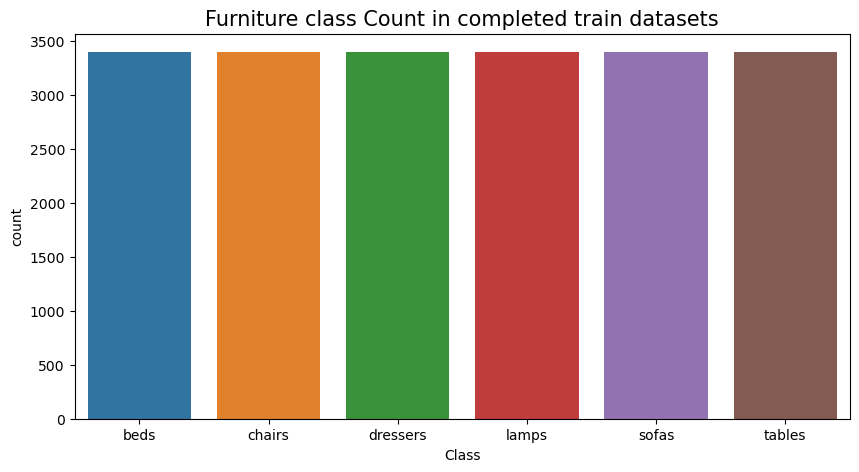

beds        3400
chairs      3400
dressers    3400
lamps       3400
sofas       3400
tables      3400
Name: Class, dtype: int64

In [29]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(df_final['Class'])
plt.title("Furniture class Count in completed train datasets", fontsize = 15)
plt.show()
df_final['Class'].value_counts()

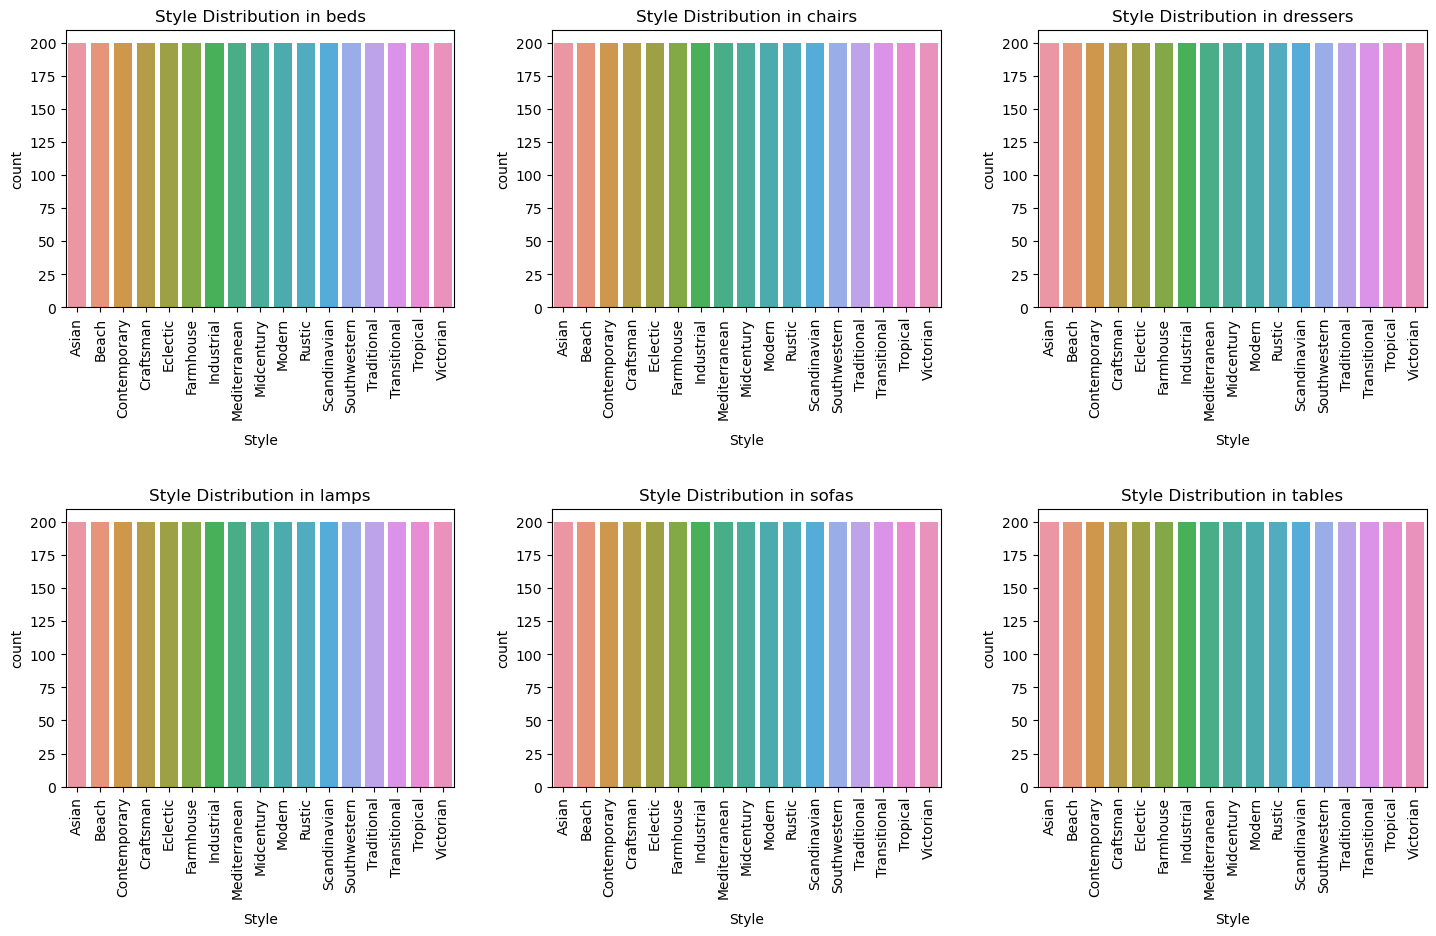

In [31]:
# Unique classes
classes = df_final['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=df_final[df_final['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [32]:
# Group by 'class' and 'style', then count occurrences
style_counts = df_final.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian            200
          Beach            200
          Contemporary     200
          Craftsman        200
          Eclectic         200
          Farmhouse        200
          Industrial       200
          Mediterranean    200
          Midcentury       200
          Modern           200
          Rustic           200
          Scandinavian     200
          Southwestern     200
          Traditional      200
          Transitional     200
          Tropical         200
          Victorian        200
chairs    Asian            200
          Beach            200
          Contemporary     200
          Craftsman        200
          Eclectic         200
          Farmhouse        200
          Industrial       200
          Mediterranean    200
          Midcentury       200
          Modern           200
          Rustic           200
          Scandinavian     200
          Southwestern     200
          Traditional      200
          Trans